In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import string
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

In [ ]:
tweets = pd.read_csv('final_tweet_master.csv')
users = pd.read_csv('final_user_master.csv')


# For EDA
tweets_eda = pd.read_csv('tweets_eda.csv')
users_eda = pd.read_csv('users_eda.csv')

In [ ]:
users.shape

(22712, 16)

In [ ]:
tweets.shape

(225717, 13)

In [ ]:
tweets.head()

,Unnamed: 0,created_at,favorite_count,id,id_str,is_tweet,lang,retweet_count,source,text,truncated,user_screen_name,user_id
0,0,2017-02-27 14:54:00,NaN,8.362279e+17,0 8.362279e+17\n1 7.651989e+17...,False,en,NaN,NaN,#ThingsDoneByMistake kissing auntie in the lips,False,kathiemrr,NaN
1,1,2016-08-15 14:50:20,NaN,7.651989e+17,0 8.362279e+17\n1 7.651989e+17...,True,en,NaN,NaN,RT @mc_derpin: #TheOlderWeGet the more pessimi...,False,traceyhappymom,NaN
2,2,2015-06-30 21:56:09,NaN,6.160023e+17,0 8.362279e+17\n1 7.651989e+17...,True,en,NaN,NaN,RT @dmataconis: Ready To Feel Like A Failure? ...,False,evewebster373,NaN
3,3,2016-09-16 08:04:48,17.0,7.766933e+17,0 8.362279e+17\n1 7.651989e+17...,False,en,18.0,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Amen! #blacklivesmatter https://t.co/wGffaOqgzl,False,blacktolive,NaN
4,4,2016-09-18 19:46:25,0.0,7.775946e+17,0 8.362279e+17\n1 7.651989e+17...,True,en,0.0,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @NahBabyNah: Twitchy: Chuck Todd caught out...,False,jacquelinisbest,NaN


In [ ]:
users.head()

,Unnamed: 0,created_at,description,favourites_count,followers_count,friends_count,id,lang,listed_count,location,name,screen_name,statuses_count,time_zone,verified,known_bot
0,0,2009-12-29 23:15:22+00:00,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,2774.0,1053.0,1055.0,100345056.0,en,35.0,still ⬆️Block⤵️Corner⬇️street,#Ezekiel2517✨...,SCOTTGOHARD,31858.0,NaN,0.0,True
1,1,2011-02-04 06:38:45+00:00,Rebecca Lynn Hirschfeld Actress.Model.Writer.A...,7273.0,650.0,896.0,247165706.0,en,30.0,"Chicago, IL",B E C K S T E R✨,Beckster319,6742.0,Mountain Time (US & Canada),0.0,True
2,2,2011-02-09 07:38:44+00:00,NaN,227.0,44.0,154.0,249538861.0,en,1.0,NaN,Chris Osborne,skatewake1994,843.0,NaN,0.0,True
3,3,2011-12-29 11:31:09+00:00,"Пародийный аккаунт. Озвучиваю то, что политика...",0.0,94773.0,7.0,449689677.0,ru,691.0,NaN,Рамзан Кадыров,KadirovRussia,10877.0,Moscow,0.0,True
4,4,2012-01-23 10:26:25+00:00,Честь имею. Нагло врать не умею.,1480.0,23305.0,8021.0,471868887.0,ru,231.0,"Санкт-Петербург, Россия",Маргарита Саваж,MargoSavazh,18401.0,Volgograd,0.0,True


In [ ]:
# Drop duplicates using the 'id' column and remove the first index column

tweets.drop_duplicates(subset=['id'], inplace=True)
tweets.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
tweets.shape

(222735, 12)

In [ ]:
# Drop duplicates and remove the index column

users.drop_duplicates(subset=['screen_name'], inplace=True)
users.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
users.shape

(681, 15)

### Data Preprocessing

In [ ]:
# Divide the users into bots, verified users and unknown users

bots = users[users['known_bot'] == True].copy()
verifieds = users[users['verified'] == True].copy()
unknowns = users[np.logical_and(users['known_bot'] != True, users['verified'] != True)].copy()

In [ ]:
# Combine the tweets and the users into one single dataframe based on type of users

tweets_bot_users = pd.merge(tweets, bots, how='right', left_on='user_screen_name', right_on='screen_name')
tweets_verified_users = pd.merge(tweets, verifieds, how='right', left_on='user_screen_name', right_on='screen_name')
tweets_unknown_users = pd.merge(tweets, unknowns, how='right', left_on='user_screen_name', right_on='screen_name')

In [ ]:
tweets_unknown_users["TypeOfUser"] = "Unknown"
tweets_bot_users["TypeOfUser"] = "Bot"
tweets_verified_users["TypeOfUser"] = "Verified"

new_tweet_df = pd.concat([tweets_unknown_users,tweets_bot_users, tweets_verified_users], ignore_index=True)

In [ ]:
# Ratio of the types of users

print("\nCounts Of Users:")
print(new_tweet_df.groupby("TypeOfUser").count()['known_bot'])
print("\nPercentages of Users:")
usr_sum = sum(new_tweet_df.groupby("TypeOfUser").count()['known_bot'])
print(new_tweet_df.groupby("TypeOfUser").count()['known_bot']/usr_sum*100)



Counts Of Users:
TypeOfUser
Bot         42862
Unknown      5796
Verified    16463
Name: known_bot, dtype: int64

Percentages of Users:
TypeOfUser
Bot         65.819014
Unknown      8.900355
Verified    25.280631
Name: known_bot, dtype: float64


### Text Processing

In [ ]:
# Divide the tweets from real users and bots

tt = TweetTokenizer()
new_tweet_df.dropna(subset=['text'], inplace=True)


useful_cols = ['followers_count','known_bot','text','tokens','name', 'is_tweet', 'tweet_length']
new_tweet_df['tokens'] = new_tweet_df['text'].apply(tt.tokenize)

new_tweet_df['tweet_length'] = new_tweet_df['tokens'].str.len()

bot_texts = new_tweet_df.loc[new_tweet_df.known_bot == True][useful_cols]
real_texts= new_tweet_df.loc[new_tweet_df.known_bot == False][useful_cols]

No handles with labels found to put in legend.



Distribution of tweet lengths by bot vs real people.




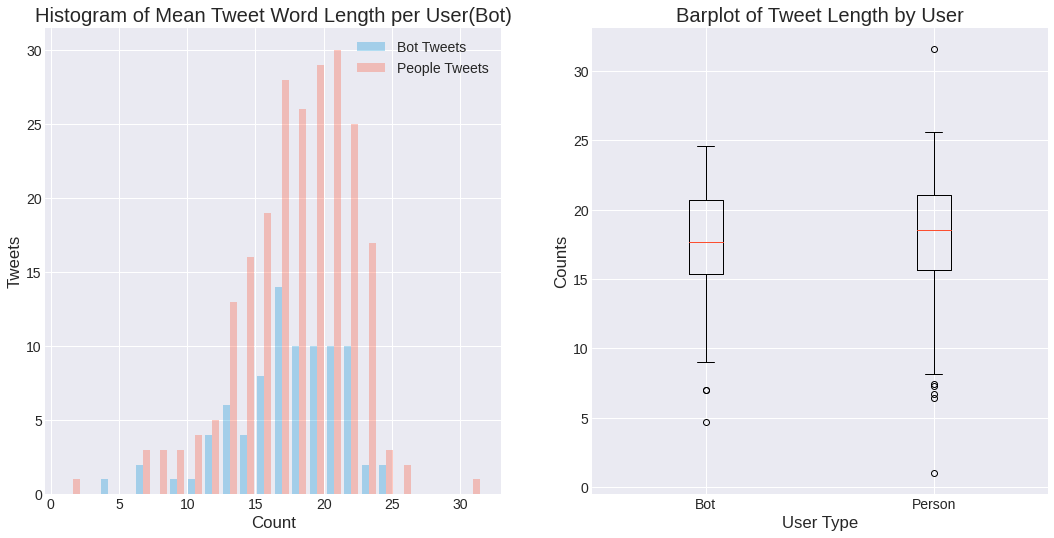

In [ ]:
# EDA

print("\nDistribution of tweet lengths by bot vs real people.\n\n")
tweet_len_by_bot = bot_texts.groupby(['name']).tweet_length.mean().sort_values(ascending=False)
tweet_len_by_usr = real_texts.groupby(['name']).tweet_length.mean().sort_values(ascending=False)


fig, ax = plt.subplots(1,2, figsize= (16,8))
ax[0].hist([tweet_len_by_bot,tweet_len_by_usr], bins = int(max(tweet_len_by_bot)), label=["Bot Tweets","People Tweets"], alpha=0.3)
ax[0].set_title("Histogram of Mean Tweet Word Length per User(Bot)")
ax[0].set_ylabel("Tweets")
ax[0].set_xlabel("Count")
ax[0].legend()

ax[1].boxplot([bot_texts.groupby(['name']).tweet_length.mean(), real_texts.groupby(['name']).tweet_length.mean()], labels = ['Bot', 'Person'])
ax[1].set_title("Barplot of Tweet Length by User")
ax[1].set_ylabel("Counts")
ax[1].set_xlabel("User Type")
ax[1].legend()

In [ ]:
 import nltk
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Text processing to calculate frequency of most used words

bot_words = bot_texts.groupby(['name']).tokens.agg(sum)
usr_words = real_texts.groupby(['name']).tokens.agg(sum)
bot_words = pd.DataFrame(bot_words)
usr_words = pd.DataFrame(usr_words)

bot_words.columns = ['words']
usr_words.columns = ['words']

stop_words  = stopwords.words('english') + list(string.punctuation) + [' ','rt',"\'", "...", "..","`",'\"', '–', '’', "I'm", '…','""','“','”']

# List of cleaned words
usr_words['cleaned_words'] = [[word for word in words if word.lower() not in stop_words] for words in usr_words['words']]
bot_words['cleaned_words'] = [[word for word in words if word.lower() not in stop_words] for words in bot_words['words']]

In [ ]:
freq_per_usr = FreqDist(list([a for b in usr_words.cleaned_words.tolist() for a in b]))
freq_per_bot = FreqDist(list([a for b in bot_words.cleaned_words.tolist() for a in b]))

# Most common words
common_words_bot = pd.DataFrame(freq_per_bot.most_common())
common_words_usr = pd.DataFrame(freq_per_usr.most_common())

cols = ["Words", "Count"]
common_words_bot.columns = cols
common_words_usr.columns = cols

common_words_usr['Frequency'] = common_words_usr['Count']/len(common_words_usr)
common_words_bot['Frequency'] = common_words_bot['Count']/len(common_words_bot)

In [ ]:
filter1 = (common_words_usr['Words'].str.len()>=3)
filter2 = (common_words_bot['Words'].str.len()>=3)


filtered_usr = common_words_usr.loc[filter1]
filtered_bot = common_words_bot.loc[filter2]

print("\nThe top 15 words used in real tweets (out of {} unique words)::\n".format(len(filtered_usr)))
print(filtered_usr[:15])
print("\nThe top 15 word used by all bots (out of {} unique words):\n".format(len(filtered_bot)))
print(filtered_bot[:15])


The top 15 words used in real tweets (out of 60126 unique words)::

               Words  Count  Frequency
1               like    600   0.009681
2             people    595   0.009600
3                one    594   0.009584
4                new    566   0.009132
5               time    539   0.008697
6                get    498   0.008035
8              Trump    466   0.007519
9               know    458   0.007390
10             Thank    453   0.007309
11  @realDonaldTrump    432   0.006970
12             Biden    399   0.006438
13             today    397   0.006406
16               see    386   0.006228
17              love    371   0.005986
18               day    357   0.005760

The top 15 word used by all bots (out of 89626 unique words):

               Words  Count  Frequency
0              Trump   4250   0.046660
1            Clinton   1916   0.021035
2            Hillary   1796   0.019718
3              Obama   1422   0.015612
4              https   1056   0.011594
5        

Using the obtained words from bots and real users, we can generalize and look at the number of users using those words

In [ ]:
bot_words = filtered_bot[:10]

# Set these to 0
for word in bot_words['Words']:
    new_tweet_df[word] = 0 # Set to 0
    new_tweet_df[word] = new_tweet_df.apply(lambda row: row['tokens'].count(word), axis=1) # Fill if counted
    
text_by_names = new_tweet_df.groupby(['name']).sum()[bot_words['Words']]
to_join = new_tweet_df[['name','known_bot']].drop_duplicates().set_index('name')
text_by_names=text_by_names.join(to_join, how='inner').drop_duplicates()
print(text_by_names.head())

               Trump  Clinton  Hillary  Obama  ...  Donald  @blicqer  via  known_bot
name                                           ...                                  
*                  0        0        0      0  ...       0         0    0      False
1-800-WOKE-AF     72        9        8     39  ...      49         0    0       True
19:37              4        1        0      1  ...       0         0    1       True
Abi Wilkinson      0        0        0      0  ...       0         0    0      False
Abigail Silk       7        1        1      0  ...       2         0    0       True

[5 rows x 11 columns]


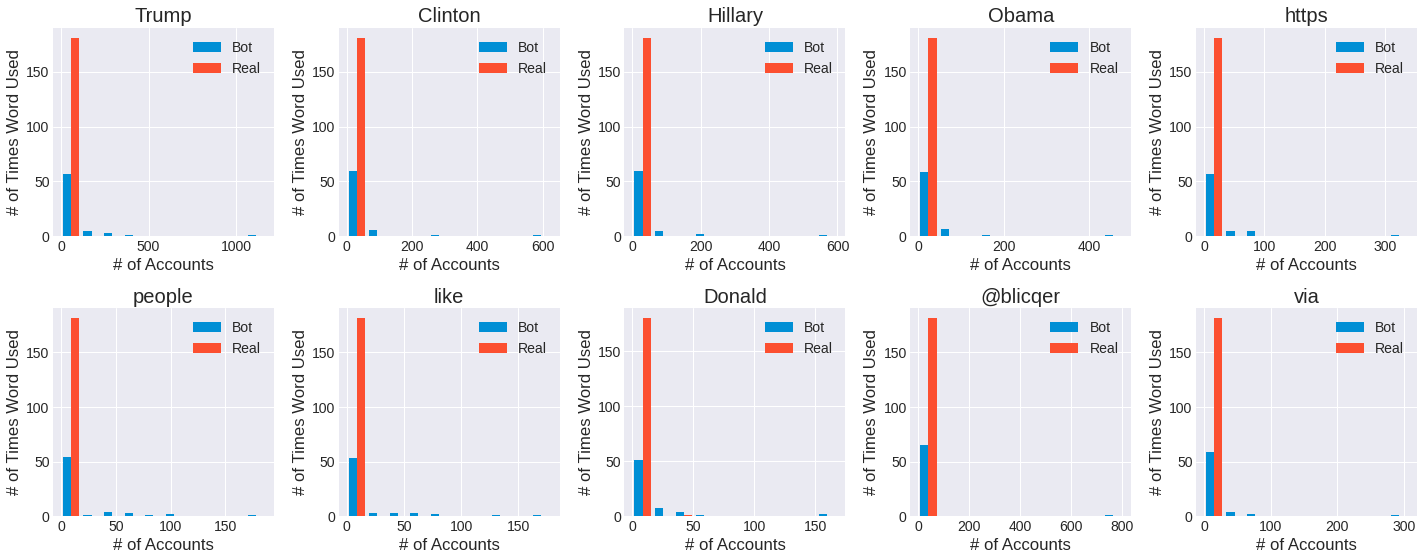

In [ ]:
bot_texts2 = text_by_names.loc[text_by_names.known_bot == True].join(tweet_len_by_bot, how='inner')
usr_texts2= text_by_names.loc[text_by_names.known_bot == False].join(tweet_len_by_usr, how='inner')

tweet_len_by_bot = pd.DataFrame(tweet_len_by_bot)
tweet_len_by_usr = pd.DataFrame(tweet_len_by_usr)

tweet_len_by_bot.columns = ['mean_tweet_length']
tweet_len_by_usr.columns = ['mean_tweet_length']


fig, ax = plt.subplots(2,5, figsize= (20,8))
ax = ax.ravel()

for i, word in enumerate(bot_words['Words']):
    ax[i].hist([bot_texts2[word], usr_texts2[word]], label=["Bot","Real"])
    ax[i].set_title(word)
    ax[i].set_ylabel('# of Times Word Used')
    ax[i].set_xlabel("# of Accounts")
    ax[i].legend()

plt.tight_layout()

In [ ]:
# ['favourite_count', 'retweet_count', 'text', 'followers_count', 'statuses_count', 'favourites_count', 'friends_count', 'listed_count', 'tweet_length']

In [ ]:
from textblob import TextBlob

def score(text) -> float:
  return TextBlob(text).sentiment.polarity

new_tweet_df['polarity_score']=new_tweet_df['text'].apply(lambda x : score(x))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(analyzer='word')

vect.fit(new_tweet_df['text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
from sklearn.model_selection import train_test_split

X = new_tweet_df['text']
y = new_tweet_df['known_bot']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train_vect = vect.transform(X_train)
#y_train_vect = vect.transform(y_train)
X_test_vect = vect.transform(X_test)
#y_test_vect = vect.transform(y_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

nb = MultinomialNB()

nb = nb.fit(X_train_vect, y_train)
scor = nb.score(X_test_vect,y_test)

print('Accuracy of Naive Bayes:', scor*100, '%')

Accuracy of Naive Bayes: 88.24952390756087 %


In [ ]:
y_pred

array([ True, False,  True, ...,  True,  True, False])

### Classification algorithms

In [ ]:
from sklearn.model_selection import train_test_split

X = new_tweet_df.filter(['retweet_count', 'followers_count', 'statuses_count', 'favourites_count', 'friends_count', 'listed_count', 'tweet_length','polarity_score'], axis=1).copy()
Y = new_tweet_df['known_bot']


tweets_unknown_users = new_tweet_df[new_tweet_df['TypeOfUser']=='Unknown']
X_unknown_test = tweets_unknown_users.filter(['favourite_count', 'retweet_count', 'followers_count', 'statuses_count', 'favourites_count', 'friends_count', 'listed_count', 'tweet_length','polarity_score'], axis=1).copy()


In [ ]:
X.isnull().sum()
#X.head()

retweet_count       31681
followers_count      2953
statuses_count       2953
favourites_count     2953
friends_count        2953
listed_count         2953
tweet_length            0
polarity_score          0
dtype: int64

In [ ]:
# Since there are a lot of missing values, we need to do mean imputation.

import math

def calculateMean(col):
  n = len(col)
  sum = 0
  for value in col:
    if math.isnan(value):
      continue
    else:
      sum += value
  return sum/n


# For original Dataset

mean_rt = calculateMean(X['retweet_count'])
mean_rt
X['retweet_count'] = X['retweet_count'].fillna(mean_rt)


mean_rt = calculateMean(X['followers_count'])
mean_rt
X['followers_count'] = X['followers_count'].fillna(mean_rt)


mean_rt = calculateMean(X['statuses_count'])
mean_rt
X['statuses_count'] = X['statuses_count'].fillna(mean_rt)


mean_rt = calculateMean(X['favourites_count'])
mean_rt
X['favourites_count'] = X['favourites_count'].fillna(mean_rt)


mean_rt = calculateMean(X['friends_count'])
mean_rt
X['friends_count'] = X['friends_count'].fillna(mean_rt)


mean_rt = calculateMean(X['listed_count'])
mean_rt
X['listed_count'] = X['listed_count'].fillna(mean_rt)





# For the unknown users dataset

mean_rt = calculateMean(X_unknown_test['retweet_count'])
mean_rt
X_unknown_test['retweet_count'] = X_unknown_test['retweet_count'].fillna(mean_rt)


mean_rt = calculateMean(X_unknown_test['followers_count'])
mean_rt
X_unknown_test['followers_count'] = X_unknown_test['followers_count'].fillna(mean_rt)


mean_rt = calculateMean(X_unknown_test['statuses_count'])
mean_rt
X_unknown_test['statuses_count'] = X_unknown_test['statuses_count'].fillna(mean_rt)


mean_rt = calculateMean(X_unknown_test['favourites_count'])
mean_rt
X_unknown_test['favourites_count'] = X_unknown_test['favourites_count'].fillna(mean_rt)


mean_rt = calculateMean(X_unknown_test['friends_count'])
mean_rt
X_unknown_test['friends_count'] = X_unknown_test['friends_count'].fillna(mean_rt)


mean_rt = calculateMean(X_unknown_test['listed_count'])
mean_rt
X_unknown_test['listed_count'] = X_unknown_test['listed_count'].fillna(mean_rt)


In [ ]:
# Test-train split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf = clf.fit(X, Y)

y_pred = clf.predict(X_test)
print('Accuracy of Random Forest:', accuracy_score(y_pred, Y_test)*100, '%')


# Apply the fitted model to the unknown users dataset
y_unknown = clf.predict(X_unknown_test)


Accuracy of Random Forest: 93.70528591281074 %


In [ ]:
for i in clf.feature_importances_:
  print(i)

0.13859364457817577
0.1917927871710287
0.2379286502585896
0.07070978938699313
0.10299038493859998
0.2542474121854578
0.0037276772711413325
9.654210013751321e-06


In [ ]:
y_unknown

array([False, False, False, ..., False, False, False])

In [ ]:
# Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=2, random_state=0)
clf = clf.fit(X, Y)

y_pred = clf.predict(X_test)
print('Accuracy of Decision Trees:', accuracy_score(y_pred, Y_test)*100, '%')

Accuracy of Decision Trees: 90.40609398322096 %


In [ ]:
# clf.feature_importances_.sort()
for i in clf.feature_importances_:
  print(i)

0.0
0.0
0.0
0.16609725803583947
0.12007774388958961
0.7138249980745709
0.0
0.0


In [ ]:
# Ratio of bots and real users in the predicted results

unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{False: 5012, True: 14417}

In [ ]:
# Check the twitter handles of the users predicted as bots

y_df = pd.DataFrame(y_unknown)
df_unknown = pd.concat([tweets_unknown_users['user_screen_name'], y_df], axis=1)

df_unknown.drop_duplicates(subset=['user_screen_name'])

,user_screen_name,0
0,The_Hank_Poggi,False
100,TheJordanRachel,False
200,ElongMusk,True
266,jeff_green22,False
366,crystaltamar,True
...,...,...
5296,DaBubbaG,False
5396,RichardDoiron15,True
5496,MarcStosoned,True
5596,BusyDrT,False


### Exploratory Data Analysis

Text(0, 0.5, 'Tweet Count')

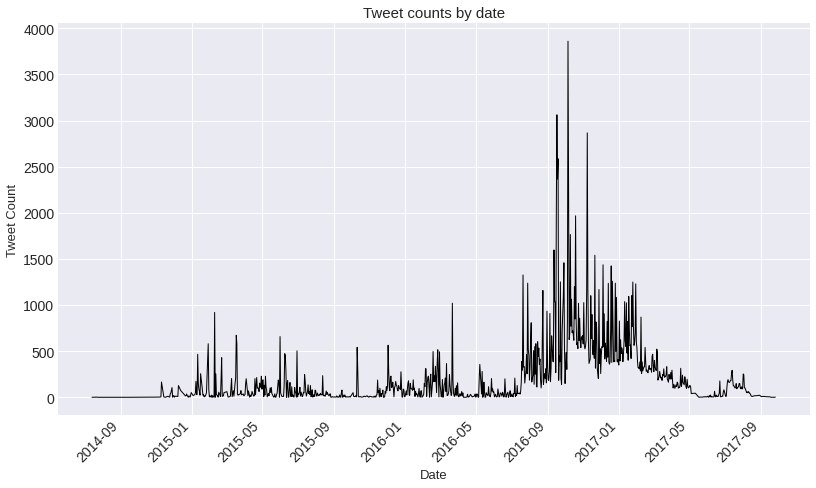

In [ ]:
# Let us observe the number of tweets by date
# Covert created_at into datetime object

tweets_eda['created_at'] = pd.to_datetime(tweets_eda['created_str'])
tweets_eda['date'] = pd.to_datetime(tweets_eda['created_at'].dt.date)

# Count the number of times a date appears in the dataset and convert to dataframe
tweet_trend = pd.DataFrame(tweets_eda['date'].value_counts())

# index is date, columns indicate tweet count on that day
tweet_trend.columns = ['tweet_count']

# sort the dataframe by the dates to have them in order
tweet_trend.sort_index(ascending = True, inplace = True)


plt.style.use('seaborn-darkgrid')
tweet_trend['tweet_count'].plot(linestyle = "-", figsize = (12,8), rot = 45, color = 'k', linewidth = 1)
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)

In [ ]:
dates_list = ['2015-06-16', '2015-12-07', '2016-02-01',
              '2016-03-01', '2016-03-03', '2016-03-11',
              '2016-05-03', '2016-05-26', '2016-06-20', 
              '2016-07-15', '2016-07-21', '2016-08-17',
              '2016-09-01', '2016-10-07', '2016-11-08']

# create a series of these dates.
important_dates = pd.Series(pd.to_datetime(dates_list))

# add columns to identify important events, and mark a 0 or 1.
tweet_trend['Important Events'] = False
tweet_trend.loc[important_dates, 'Important Events'] = True
tweet_trend['values'] = 0
tweet_trend.loc[important_dates, 'values'] = 1

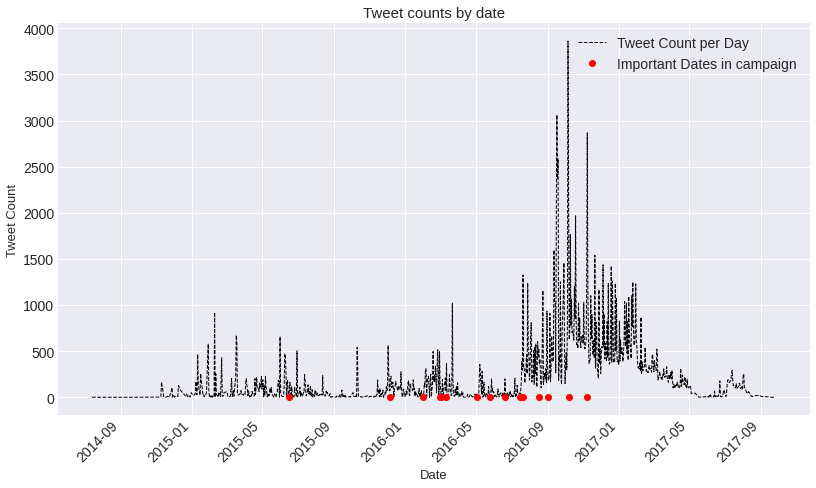

In [ ]:
# plot the line chart for trend, a monthly average of tweet counts and add red dots to 
# mark important events.
plt.style.use('seaborn-darkgrid')
tweet_trend['tweet_count'].plot(linestyle = "--", 
                                figsize = (12,8), rot = 45, 
                                color = 'k',
                                label = 'Tweet Count per Day',
                               linewidth = 1)

# plot dots for where values in the tweet_trend df are 1
plt.plot(tweet_trend[tweet_trend['Important Events'] == True].index.values,
         tweet_trend.loc[tweet_trend['Important Events'] == True, 'values'],
         marker = 'o', 
         color = 'r',
         linestyle = 'none',
        label = 'Important Dates in campaign')


plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)
plt.legend(loc = 'best')

In [ ]:
# Text pre-processing

tweets_eda.dropna(subset=['text'], inplace=True)


import re

# define a function that takes in a tweet and throws out the text without the RT.
def remove_retweet(tweet):
    text_only = []
    if len(re.findall("^RT.*?:(.*)", tweet)) > 0:
        text_only.append(re.findall("^RT.*?:(.*)", tweet)[0])
    else:
        text_only.append(tweet)
    return text_only[0]

# extract texts and place in a list
text_processed = tweets_eda['text'].map(remove_retweet)

In [ ]:
# this method checks for links and removes these from the tweet provided!
def remove_links(tweet):
    text_only = []
    if len(re.findall("(https://[^\s]+)", tweet)) > 0:
        tweet = re.sub("(https://[^\s]+)", "", tweet)
    if len(re.findall("(http://[^\s]+)", tweet)) > 0:
        tweet = re.sub("(http://[^\s]+)", "", tweet)    
    text_only.append(tweet)
    return text_only[0]

text_processed = text_processed.map(remove_links)

In [ ]:
def remove_hashtags(tweet):
    hashtags_only = []
    if len(re.findall("(#[^#\s]+)", tweet)) > 0:
        tweet = re.sub("(#[^#\s]+)", "", tweet) 
    hashtags_only.append(tweet)
    return hashtags_only[0]

text_processed = text_processed.map(remove_hashtags)

In [ ]:
def remove_spaces(tweet):
    tweet = tweet.rstrip()
    tweet = tweet.lstrip()
    tweet = tweet.rstrip(")")
    tweet = tweet.lstrip("(")
    tweet = re.sub("\.", "", tweet)
    return tweet

text_processed = text_processed.map(remove_spaces)

In [ ]:
# in case no mention present, we return "0"
def extract_mentions(tweet):
    mentions = []
    if len(re.findall('@[^\s@]+', tweet))>0:
        mentions.append(re.findall('@([^\s@]+)', tweet))
    else:
        mentions.append(["0"])
    return mentions[0]

# Put the user mentions in a new column in our dataframe
tweets_eda['mentions'] = text_processed.map(extract_mentions)

In [ ]:
# Now lets remove the mentions from the tweet text
def remove_mentions(tweet):
    '''Given a text, remove the user mentions'''
    mentions = []
    if len(re.findall('@[^\s@]+', tweet))>0:
        tweet = re.sub('@[^\s@]+', "" , tweet)
        mentions.append(tweet)
    else:
        mentions.append(tweet)
    return mentions[0]

text_processed = text_processed.map(remove_mentions)

In [ ]:
tweets_eda['text_processed'] = text_processed

In [ ]:
def extract_hashtags(tweet):
    '''Provide a tweet and extract hashtags from it'''
    hashtags_only = []
    if len(re.findall("(#[^#\s]+)", tweet)) > 0:
        hashtags_only.append(re.findall("(#[^#\s]+)", tweet))
    else:
        hashtags_only.append(["0"])
    return hashtags_only[0]

# make a new column to store the extracted hashtags and view them!
tweets_eda['hashtags'] = tweets_eda['text'].map(extract_hashtags)
tweets_eda['hashtags'].head(10)

0                          [#IslamKills]
1                                    [0]
2                                    [0]
3                  [#ChristmasAftermath]
4                                    [0]
5                                    [0]
6                                    [0]
7                                    [0]
8                                    [0]
9    [#BlackLivesMatter, #BlackPressDay]
Name: hashtags, dtype: object

In [ ]:
all_hashtags = tweets_eda['hashtags'].tolist()

# Next we observe that our all_hashtags is a list of lists...lets change that
cleaned_hashtags = []
for i in all_hashtags:
  for j in i:
    cleaned_hashtags.append(j)

# Convert cleaned_hashtags to a series and count the most frequent occuring
cleaned_hashtag_series = pd.Series(cleaned_hashtags)
hashtag_counts = cleaned_hashtag_series.value_counts()

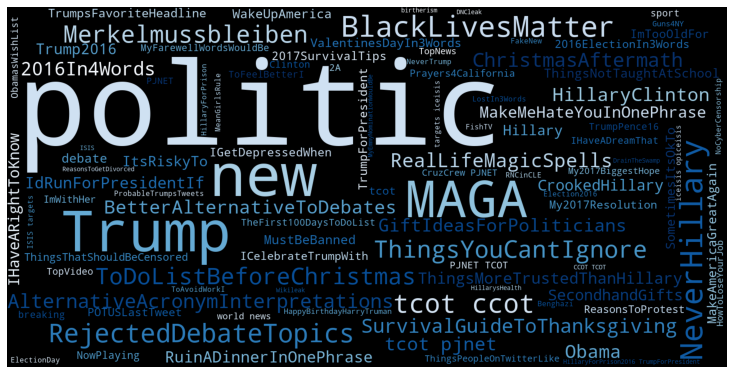

In [ ]:
#  Get hashtag terms from the series and convert to list
hashes = cleaned_hashtag_series.values
hashes = hashes.tolist()

# convert list to one string with all the words
hashes_words = " ".join(hashes)

# generate the wordcloud. the max_words argument controls the number of words on the cloud
from wordcloud import WordCloud
wordcloud = WordCloud(width= 1600, height = 800, relative_scaling = 1.0, colormap = "Blues", max_words = 100).generate(hashes_words)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


Text(0, 0.5, 'Hashtags')

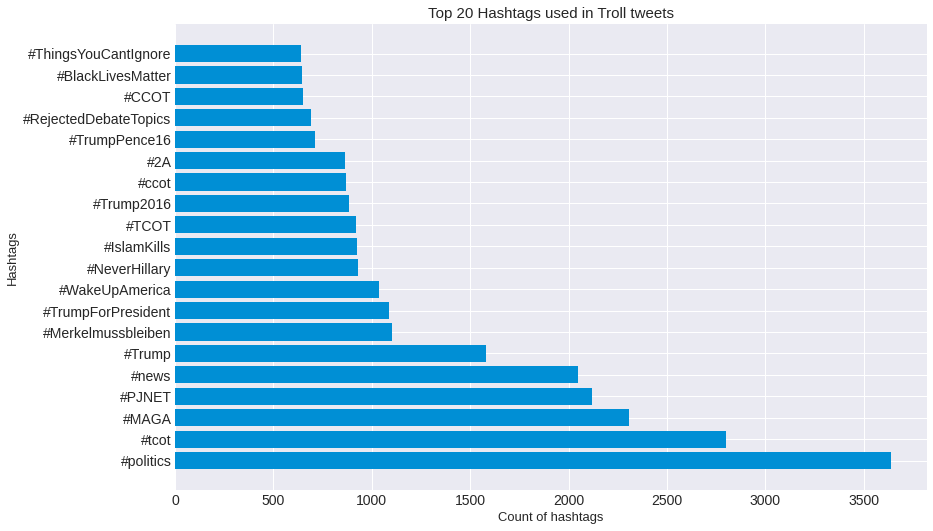

In [ ]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize = (12,8))
plt.barh(y = hashtag_counts[1:21].index.values, width = hashtag_counts[1:21])
plt.title("Top 20 Hashtags used in Troll tweets", fontsize = 15)
plt.xlabel('Count of hashtags', fontsize = 13)
plt.ylabel('Hashtags', fontsize = 13)

When were the user profiles created?


In [ ]:
# First we convert the created_at to datetime and then extract the date from this
users_eda['created_at'] = pd.to_datetime(users_eda['created_at'])
users_eda['created_at_date'] = pd.to_datetime(users_eda['created_at'].dt.date)

users_eda['created_at_date'].head()


0   2009-01-07
1   2009-12-29
2   2011-02-04
3   2011-02-09
4   2011-12-29
Name: created_at_date, dtype: datetime64[ns]

Text(0, 0.5, 'Count of accounts created')

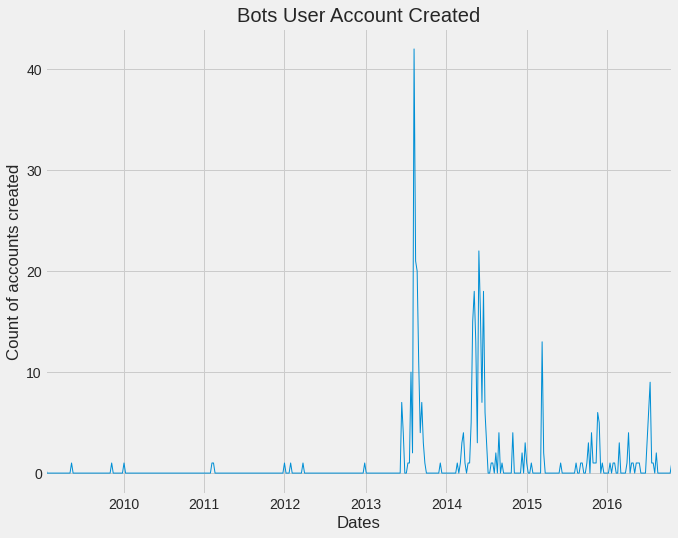

In [ ]:
user_created = users_eda.groupby('created_at_date')['id'].agg('count')

plt.style.use('fivethirtyeight')
user_created.resample('W',kind = 'period').sum().\
plot(linestyle = '-', figsize = (10,8), linewidth = 1)
plt.title('Bots User Account Created')
plt.xlabel('Dates')
plt.ylabel('Count of accounts created')

Users who tweet the most

In [ ]:
user_tweet_count = tweets_eda.groupby('user_id')['text'].agg('count').reset_index()
user_tweet_count.rename(columns = {'text':'Tweet_count'}, inplace = True)

In [ ]:
user_tweet_count_df = user_tweet_count.merge(users_eda,
                                      left_on = 'user_id',
                                      right_on = 'id')
user_tweet_count_df.head(2)

,user_id,Tweet_count,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count,created_at_date
0,18710816.0,31,18710816.0,near Utah Ave & Lighthouse an,Robby Delaware,304.0,11484.0,Pacific Time (US & Canada),False,en,RobbyDelaware,"I support the free movement of people, ideas a...",2009-01-07 04:38:02+00:00,17.0,670.0,13.0,2009-01-07
1,38875764.0,1,38875764.0,St-Petersburg,Olga,14.0,219.0,St. Petersburg,False,ru,Leecory,here i am~,2009-05-09 15:58:34+00:00,0.0,6.0,0.0,2009-05-09


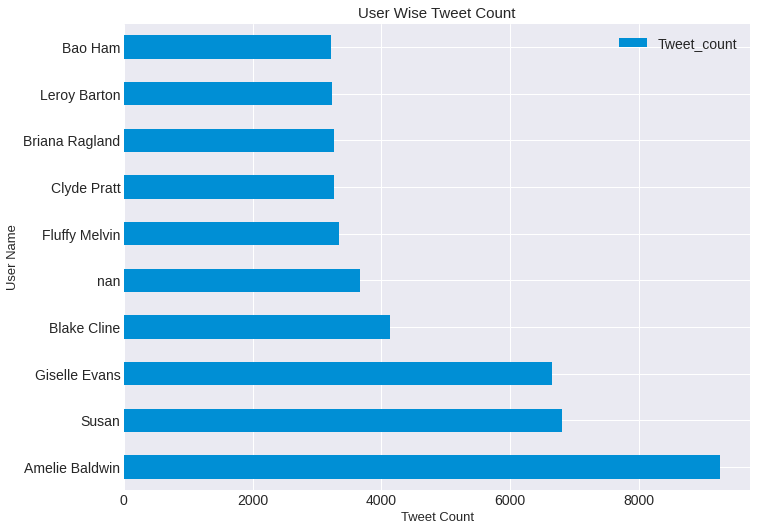

In [ ]:
plt.style.use('seaborn-darkgrid')
user_tweet_count_df[['name', 'Tweet_count']].sort_values('Tweet_count', ascending = False)[:10].\
set_index('name').plot(kind = 'barh', figsize = (10,8))
plt.title('User Wise Tweet Count', fontsize = 15)
plt.xlabel('Tweet Count', fontsize = 13)
plt.ylabel('User Name', fontsize = 13)
plt.legend()

In [ ]:
user_tweet_count_df[['name', 'lang', 'followers_count']].sort_values('followers_count', ascending = False)[:10]

,name,lang,followers_count
292,Максим Дементьев,ru,98412.0
6,Рамзан Кадыров,ru,94773.0
295,Jenna Abrams,en,61609.0
288,New York City Today,en,60897.0
281,Мюсли Лаврова,ru,47080.0
146,Холодная Война 2.0,ru,44470.0
234,Politweecs,en,32846.0
287,Washington Online,en,31729.0
297,Pigeon Today,en,29524.0
189,New Orleans Online,en,27745.0


In [ ]:
# First we get a count of users from each time-zone and language combination!
user_loc_lang = users_eda.groupby(['time_zone', 'lang'])['id'].agg('count').reset_index()
user_loc_lang.rename(columns = {'id':'user_count'}, inplace = True)
user_loc_lang.head(5)

,time_zone,lang,user_count
0,Abu Dhabi,en,1
1,Arizona,en,1
2,Baku,en,2
3,Baku,ru,4
4,Berlin,de,10


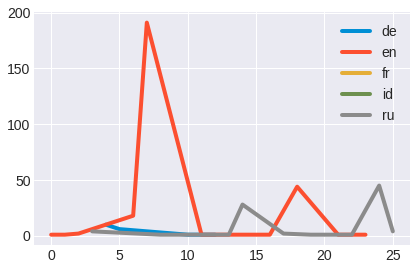

In [ ]:
# Users grouped by language
user_loc_lang.groupby('lang')['user_count'].plot()
plt.legend()